In [1]:
import pandas as pd
import os
from pathlib import Path
import ast
import matplotlib.pyplot as plt


In [2]:
# loading data
rawDataPath = Path("./raw_data")
abff0  = pd.read_csv(rawDataPath/'abff_0.csv')
abff1  = pd.read_csv(rawDataPath/'abff_1.csv')
abff2  = pd.read_csv(rawDataPath/'abff_2.csv')
ins    = pd.read_csv(rawDataPath/'INS.csv')
raw_df = pd.read_csv(rawDataPath/'order_df_20251218.csv')

In [4]:
# export OpMode in raw_df
raw_df['OPMode'] = raw_df['Running'].apply(
    lambda x: ast.literal_eval(x).get('OPMode'))

In [11]:
len(raw_df)

8665

In [5]:
maindf = raw_df.loc[
    raw_df['OPMode'] == 'NAV',
    ['UnitNumber', 'FlagChangeTime', 'WaitReportTime']
].copy()

maindf['FlagChangeTime'] = pd.to_datetime(maindf['FlagChangeTime'], unit = 's', utc=True).dt.tz_convert('Asia/Shanghai')
maindf['WaitReportTime'] = pd.to_datetime(maindf['WaitReportTime'], unit = 's', utc=True).dt.tz_convert('Asia/Shanghai')

In [6]:
ins['INSTime'] = pd.to_datetime(ins['inschangetime'].str.replace(',', ''), unit = 's', utc=True).dt.tz_convert('Asia/Shanghai')

C:\Users\AnRaymon\AppData\Local\Temp\ipykernel_35996\1826138062.py:1: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  ins['INSTime'] = pd.to_datetime(ins['inschangetime'].str.replace(',', ''), unit = 's', utc=True).dt.tz_convert('Asia/Shanghai')


In [7]:
len(maindf)

1049

INS not happend in the window time of maindf

In [8]:
keep_mask = ~maindf.apply(
    lambda row: (
        (row['UnitNumber'] == ins['UnitNumber']) &
        (ins['INSTime'] >= row['FlagChangeTime']) &
        (ins['INSTime'] <= row['WaitReportTime'])
    ).any(),
    axis=1
)

In [10]:
len(maindf[keep_mask])

923

In [12]:
maindf = maindf[keep_mask].copy()

ABFF data combine and merge

In [14]:
combined_abff = pd.concat([abff1, abff2, abff0], ignore_index=True)

In [15]:
combined_abff['SignalTime'] = pd.to_datetime(combined_abff['changetime'].str.replace(',', ''), unit = 's', utc=True).dt.tz_convert('Asia/Shanghai')
combined_abff['Signal'] = combined_abff['abff'].apply(lambda x: 1 if x == 1 or x == 2 else 0)

C:\Users\AnRaymon\AppData\Local\Temp\ipykernel_35996\2243768392.py:1: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  combined_abff['SignalTime'] = pd.to_datetime(combined_abff['changetime'].str.replace(',', ''), unit = 's', utc=True).dt.tz_convert('Asia/Shanghai')


In [16]:
maindf = maindf.sort_values(['UnitNumber', 'FlagChangeTime'])
combined_abff = combined_abff.sort_values(['UnitNumber', 'SignalTime'])

In [24]:
merged = pd.merge(
    left=maindf,
    right=combined_abff,
    on='UnitNumber',
    suffixes=('_main','_abff')
)
len(merged)

224424

In [25]:
# exclude the timestamp that out of the window time
merged = merged[
    (merged['SignalTime'] <= merged['WaitReportTime']) &
    (merged['SignalTime'] >= merged['FlagChangeTime'])
].copy()

len(merged)

20004

In [27]:
# exclude elevator not in the same floor
merged['uid'] = list(zip(merged['UnitNumber'], merged['FlagChangeTime']))
floor_counts = merged.groupby("uid")['floor'].nunique()
valid_units = floor_counts[floor_counts == 1].index

merged = merged[merged['uid'].isin(valid_units)].copy()
len(merged)

18819

In [30]:
# exclude those elevators whose last sigal is not 1

lastSig_mask = merged.groupby('uid')['Signal'].transform('last') == 1
merged = merged[lastSig_mask].copy()
len(merged)

17677

In [31]:
merged = merged.sort_values(['uid', 'SignalTime'])

ng = merged.groupby('uid', sort=False)

prev_signal = ng['Signal'].shift(1)
prev_time   = ng['SignalTime'].shift(1)

merged['zero_to_1_interval'] = merged['SignalTime'].sub(prev_time).where(
    (prev_signal == 0) & (merged['Signal'] == 1))

In [35]:
result = merged[(merged['opmode']=='NAV') & (merged['Signal'] == 1) & (merged['zero_to_1_interval'].notna())].copy()
len(result)

8433

In [40]:
print("report window count: ", result.uid.nunique())
print("Elevator count: ", result.UnitNumber.nunique())

report window count:  305
Elevator count:  12


Show distribution

In [41]:
result["zero_to_1_interval_seconds"] = result['zero_to_1_interval'].dt.total_seconds()
result["zero_to_1_interval_seconds"].describe()

count    8433.000000
mean        3.551524
std        95.521054
min         2.000000
25%         2.000000
50%         2.000000
75%         3.000000
max      8766.000000
Name: zero_to_1_interval_seconds, dtype: float64

<Axes: ylabel='Frequency'>

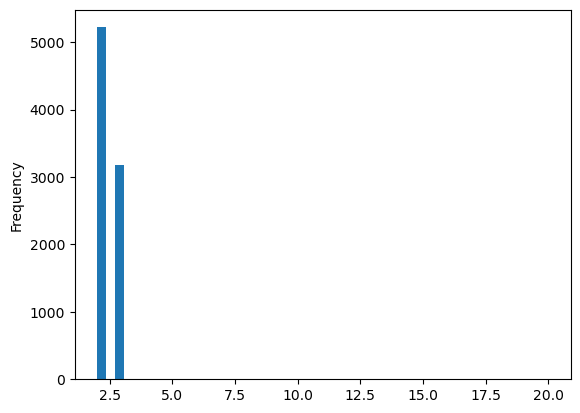

In [43]:
result["zero_to_1_interval_seconds"].clip(upper=20).plot.hist(bins=50)

In [46]:
len(result[result["zero_to_1_interval_seconds"]==2])

5220

In [48]:
result[result["zero_to_1_interval_seconds"]==2].uid.nunique()

267

In [49]:
result[result["zero_to_1_interval_seconds"]==3].uid.nunique()

221